"H.S." ;) is going to have to wait for sometime... BUT we can do it!


!!! Though we cannot find a reason for it: the plots do not load (as they actually should). Only white brackets show up and these are not even displayed in the .html.

# Exercise 5 | Tomography

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook   # cross feedback

from scipy.sparse import dok_matrix, coo_matrix
from scipy.sparse.linalg import lsqr

<div style="color: green; font-weight: bold">When removing %matplotlib notebook, the plots appear as they should</div>
<div style="color: green; font-weight: bold">Also: your solution is identical to the sample solution??</div>

## 5.1

In [2]:
def construct_X_slow(M, alphas, Np = None):
    
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0: Np += 1

    # sparse matrix
    X = dok_matrix((M*M, len(alphas)*Np), dtype = np.float32)

    for i, alpha in enumerate(alphas): # go through the angles
        # convert angle and prepare rotation matrix
        alph_rad = np.radians(alpha)
        rotated_mat = np.array([[np.cos(alph_rad), -np.sin(alph_rad)],
                            [np.sin(alph_rad),  np.cos(alph_rad)]])
        
        for y in range(M):  # go through img coordinates
            for x in range(M):
                
                p = x - (M-1)/2
                q = y - (M-1)/2
                
                p, q = rotated_mat.dot([p,q])
                
                xcor_on_sensor = p + (Np-1)/2
                
                # search for neighbour sensor bins
                bin0 = int(np.floor(xcor_on_sensor))
                bin1 = int(np.ceil(xcor_on_sensor))
                
               
                if bin0 == bin1:
                    X[y*M + x, i*Np + bin0] = 1.0
                else:
                    val0 = bin1 - xcor_on_sensor
                    val1 = xcor_on_sensor - bin0
                    
                    if bin1 == 0:
                        X[y*M + x, i*Np] = val1
                    elif bin0 == Np - 1:
                        X[y*M + x, i*Np + bin0] = val0
                    else:
                        X[y*M + x, i*Np + bin0] = val0
                        X[y*M + x, i*Np + bin1] = val1                

    return X.T # maybe switch dimensions in the first place?

In [3]:
def construct_X(M, alphas, Np = None):
    D = M*M
    
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0: Np += 1
        
    # number of angles
    angles_nr = len(alphas)
    
    # flattened output coordinates
    j = np.mgrid[0:D].astype(np.int32)
    # coordinate matrix for the output pixels
    M2 = (M-1) / 2
    grid = np.mgrid[-M2:M-M2,-M2:M-M2].swapaxes(1,2).reshape(2,D)
    
    # collect indices and corresponding values for all iterations
    i_indices = []
    j_indices = []
    weights = []
    
    for k, alpha in enumerate(alphas):
        # convert angle and prepare projection vector
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        # compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i+1) - proj

        # make sure rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)

        i_indices.append((i + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
        # compute sensor indices and weights above the projected points
        w = proj - i
        i_indices.append((i+1 + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])

    # construct matrix X
    i = np.concatenate(i_indices).astype(np.int32)
    j = np.concatenate(j_indices).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i,j)), shape = (angles_nr*Np, D), dtype = np.float32)

    return X


# check correctness
a = [-90,-45,0,45]
X = construct_X(10, a)
XS = construct_X_slow(10, a)
print('Loop-based and vectorized matrix give', 'same' if (X != XS).size == 0 else 'different', 'result')

Loop-based and vectorized matrix give different result


<div style="color: green; font-weight: bold">Looks good</div>

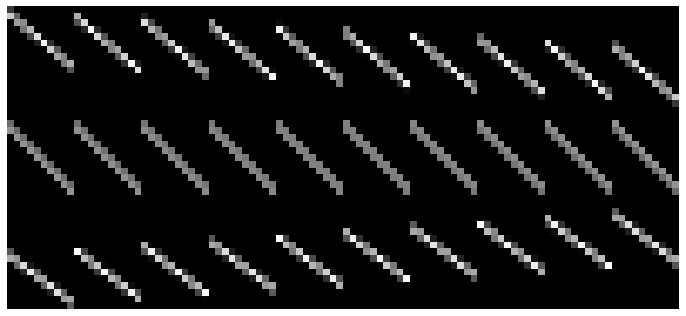

In [4]:
X = construct_X(10, [-33, 1, 42]).todense()
# np.save('X_example', X)

fig = plt.figure(figsize = (10, 4.5))
plt.imshow(X, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

## 5.2

In [5]:
%%time
y_small = np.load('hs_tomography/y_77.npy')
a_small = np.load('hs_tomography/alphas_77.npy')

X_small = construct_X(77, a_small, 109).tocsc()

print('X.shape:', X_small.shape[0], 'x', X_small.shape[1], 'effect:', round(100 * (1 - X_small.nnz / np.prod(X_small.shape)), 2))

X.shape: 9810 x 5929 effect: 98.17
CPU times: user 441 ms, sys: 1.1 s, total: 1.55 s
Wall time: 332 ms


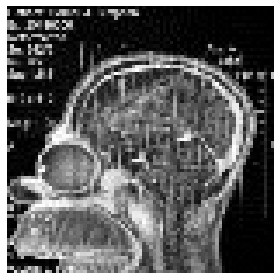

CPU times: user 1.97 s, sys: 180 ms, total: 2.15 s
Wall time: 1.93 s


In [6]:
%%time
b_small = lsqr(X_small, y_small, atol = 1e-5, btol = 1e-5)[0].reshape(77,77)

fig = plt.figure(figsize = (4,4))
plt.imshow(b_small, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()


In [7]:
%%time
y = np.load('hs_tomography/y_195.npy')
a = np.load('hs_tomography/alphas_195.npy')

X = construct_X(195, a, 275).tocsc()

print('X.Shape', X.shape[0], 'x', X.shape[1], 'effect:', round(100 * (1 - X.nnz / np.prod(X.shape)), 2))

X.Shape 49225 x 38025 effect: 99.27
CPU times: user 1.9 s, sys: 4.03 s, total: 5.93 s
Wall time: 1.74 s


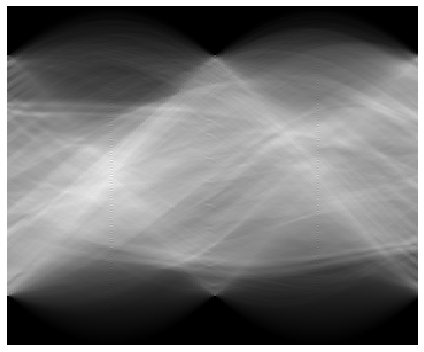

In [8]:
fig = plt.figure(figsize = (6,5))
plt.imshow(np.load('hs_tomography/y_195.npy').reshape(179,275).T, interpolation = 'nearest', aspect = 'auto')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

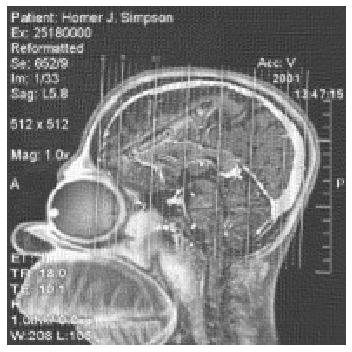

CPU times: user 1min 15s, sys: 3min 2s, total: 4min 17s
Wall time: 45.3 s


In [9]:
%%time
beta = lsqr(X, y, atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

fig = plt.figure(figsize = (5,5))
plt.imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

## 5.3

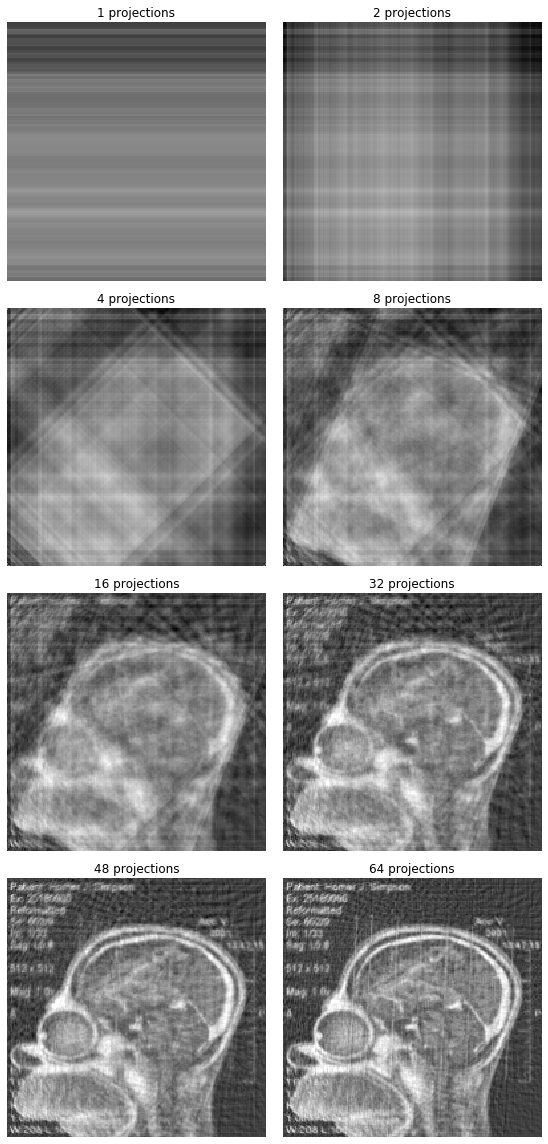

CPU times: user 59.9 s, sys: 2min 22s, total: 3min 22s
Wall time: 30.1 s


In [10]:
%%time

# set up data
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# testing numbers of projection angles
n_projections = [1, 2, 4, 8, 16, 32, 48, 64]

fig, axes = plt.subplots(4, 2, figsize = (8,16))

for n in range(len(n_projections)):
    index = [int(np.ceil(len(alphas) * p/n_projections[n])) for p in range(n_projections[n])]
    alphas_sub = alphas[index]

    #corresponding values from y
    y_sub = []
    for i in index:
        y_sub.extend(y[i*Np : (i+1)*Np])

    # matrix and reconstr im
    X = construct_X(195, alphas_sub, Np).tocsc()
    beta = lsqr(X, np.array(y_sub), atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

    # plot
    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('{} projections'.format(n_projections[n])); axes.flat[n].axis('off')

fig.tight_layout()
plt.show()

In [11]:
%%time

# set up data
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# pick 48 angles
index = [int(np.ceil(len(alphas) * p/48)) for p in range(48)]
alphas_sub = alphas[index]

#corresponding values from y
y_sub = []
for i in index:
    y_sub.extend(y[i*Np : (i+1)*Np])

#matrix and reconstr im
X = construct_X(195, alphas_sub, Np).tocsc()
beta = lsqr(X, np.array(y_sub), atol = 1e-7, btol = 1e-7)[0].reshape(195,195)

#plot
fig = plt.figure(figsize = (5,5))
plt.imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
plt.gray(); plt.axis('off'); fig.tight_layout(); plt.show()

**<span style="color:green;font-weight:bold"> Unfortunately our plots are not showing our results, but nontheless the code seems to work</span>**